# 1 数据探查与分析

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pickle

import warnings
warnings.filterwarnings('ignore')

# 为了在plt中正确显示中文
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

## 1.1 加载数据, 划分训练/测试集

In [2]:
# 划分训练集/测试集
# 由于业务场景是实现“知道一个客户40个特征，应当推送哪些基金”, 所以仅对客户数据划分训练/测试集, 而基金数据则作为通用的背景数据
client_unsplit = pd.read_csv('../data/raw/客户数据.csv')
client_train, client_test = train_test_split(client_unsplit, test_size=0.2, random_state=42)
client_train.drop(columns=['Unnamed: 0']).to_csv('../data/raw/客户train.csv')
client_test.drop(columns=['Unnamed: 0']).to_csv('../data/raw/客户test.csv')

fund_data = pd.read_csv('../data/raw/基金数据.csv')

# 加载训练集
client_train = pd.read_csv('../data/raw/客户train.csv')

## 1.2 检查空缺值

In [3]:
# 检查空缺值的数量
def count_blank_and_nan_entries(df):
    """Counts the number of blank and NaN entries in each column of a DataFrame."""
    blank_nan_counts = {}
    for column in df.columns:
        if df[column].dtype == 'object':
            # 计数空/空白字符串
            blank_nan_counts[column] = df[column].apply(lambda x: x.strip() == '').sum()
        else:
            # 计数未填充的数值
            blank_nan_counts[column] = df[column].isna().sum()
    return blank_nan_counts

In [4]:
# 首先将 '基金成立时间' 列的日期字符串转换为 datetime 对象
fund_data = fund_data.drop(columns=['Unnamed: 0'])
fund_data['基金成立时间'] = pd.to_datetime(fund_data['基金成立时间'], errors='coerce')
current_date = pd.Timestamp('today')
fund_data['成立时间距今天数'] = (current_date - fund_data['基金成立时间']).dt.days
# 舍弃基金成立时间列
fund_data = fund_data.drop(columns=['基金成立时间'])

fund_data_info = fund_data.info()
fund_data_head = fund_data.head()

print(fund_data_info, fund_data_head)

# 计数每列缺失的个数
fund_blank_nan_entries = count_blank_and_nan_entries(fund_data)
fund_blank_nan_entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   基金代码       200 non-null    object 
 1   基金公司       200 non-null    object 
 2   净值         200 non-null    float64
 3   feature1   200 non-null    int64  
 4   feature2   200 non-null    int64  
 5   feature3   200 non-null    int64  
 6   feature4   200 non-null    int64  
 7   feature5   200 non-null    int64  
 8   feature6   200 non-null    float64
 9   feature7   200 non-null    int64  
 10  feature8   200 non-null    int64  
 11  feature9   200 non-null    int64  
 12  feature10  200 non-null    float64
 13  feature11  200 non-null    float64
 14  feature12  200 non-null    float64
 15  feature13  200 non-null    int64  
 16  feature14  200 non-null    float64
 17  feature15  200 non-null    float64
 18  feature16  200 non-null    float64
 19  feature17  200 non-null    int64  
 20  feature18 

{'基金代码': 0,
 '基金公司': 0,
 '净值': 0,
 'feature1': 0,
 'feature2': 0,
 'feature3': 0,
 'feature4': 0,
 'feature5': 0,
 'feature6': 0,
 'feature7': 0,
 'feature8': 0,
 'feature9': 0,
 'feature10': 0,
 'feature11': 0,
 'feature12': 0,
 'feature13': 0,
 'feature14': 0,
 'feature15': 0,
 'feature16': 0,
 'feature17': 0,
 'feature18': 0,
 'feature19': 0,
 'feature20': 0,
 'feature21': 0,
 'feature22': 0,
 'feature23': 0,
 'feature24': 0,
 'feature25': 0,
 'feature26': 0,
 'feature27': 0,
 'feature28': 0,
 'feature29': 0,
 'feature30': 0,
 '成立时间距今天数': 0}

In [5]:
client_data = client_train.drop(columns=['Unnamed: 0'])
# client_data['客户公司编号'] = client_data['客户公司编号'].apply(str)
# 舍弃公司编号, 这与公司名称是一样的
client_data = client_data.drop(columns=['客户公司编号'])

client_data_info = client_data.info()
client_data_head = client_data.head()

print(client_data_info, client_data_head)

# 计数每列缺失的个数
client_blank_nan_entries = count_blank_and_nan_entries(client_data)
client_blank_nan_entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 46 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   客户编号       9600 non-null   object 
 1   客户公司名称     9600 non-null   object 
 2   feature1   9511 non-null   float64
 3   feature2   9497 non-null   float64
 4   feature3   9511 non-null   float64
 5   feature4   9515 non-null   float64
 6   feature5   9512 non-null   float64
 7   feature6   9517 non-null   float64
 8   feature7   9514 non-null   float64
 9   feature8   9508 non-null   float64
 10  feature9   9514 non-null   float64
 11  feature10  9496 non-null   float64
 12  feature11  9525 non-null   float64
 13  feature12  9495 non-null   float64
 14  feature13  9509 non-null   float64
 15  feature14  9533 non-null   float64
 16  feature15  9496 non-null   float64
 17  feature16  9481 non-null   float64
 18  feature17  9524 non-null   float64
 19  feature18  9505 non-null   float64
 20  feature1

{'客户编号': 0,
 '客户公司名称': 0,
 'feature1': 89,
 'feature2': 103,
 'feature3': 89,
 'feature4': 85,
 'feature5': 88,
 'feature6': 83,
 'feature7': 86,
 'feature8': 92,
 'feature9': 86,
 'feature10': 104,
 'feature11': 75,
 'feature12': 105,
 'feature13': 91,
 'feature14': 67,
 'feature15': 104,
 'feature16': 119,
 'feature17': 76,
 'feature18': 95,
 'feature19': 87,
 'feature20': 109,
 'feature21': 87,
 'feature22': 9264,
 'feature23': 100,
 'feature24': 85,
 'feature25': 79,
 'feature26': 88,
 'feature27': 68,
 'feature28': 75,
 'feature29': 87,
 'feature30': 112,
 'feature31': 94,
 'feature32': 100,
 'feature33': 73,
 'feature34': 78,
 'feature35': 93,
 'feature36': 84,
 'feature37': 94,
 'feature38': 76,
 'feature39': 98,
 'feature40': 86,
 '第一选择基金': 5776,
 '第二选择基金': 8244,
 '第三选择基金': 9259,
 '第四选择基金': 9525}

In [6]:
# 处理成立日期, 并删除冗余的index列
def process_fund_date(fund_data):
    # 删除不必要的列
    fund_data = fund_data.drop(columns=['Unnamed: 0'])

    # 将 '基金成立时间' 列的日期字符串转换为 datetime 对象
    fund_data['基金成立时间'] = pd.to_datetime(fund_data['基金成立时间'], errors='coerce')

    # 计算 '成立时间距今天数'
    current_date = pd.Timestamp('today')
    fund_data['成立时间距今天数'] = (current_date - fund_data['基金成立时间']).dt.days

    # 舍弃 '基金成立时间' 列
    fund_data = fund_data.drop(columns=['基金成立时间'])

    # 返回处理后的数据
    return fund_data
# processed_fund_date = process_fund_data(fund_data)

In [7]:
# 删除冗余的index, 客户公司编号(此与客户公司名称一一对应)
def remove_redundant_client_col(client_data):
    # 删除不必要的列
    client_data = client_data.drop(columns=['Unnamed: 0', '客户公司编号'])

    # 返回处理后的数据
    return client_data

## 1.3 删除无效信息列, 并填充空缺值

In [8]:
def remove_noninf(df, noninf_columns_file='../models/noninf_columns.pkl', is_train=True, threshold=0.95):
    if is_train:
        # 识别无效列: 空缺率/重复率 > threshold
        noninf_columns = []
        for column in df.columns:
            if column in {'第一选择基金', '第二选择基金', '第三选择基金', '第四选择基金'}:
                continue
            most_common_value = df[column].mode()[0]
            most_common_frac = (df[column] == most_common_value).mean()
            if df[column].isna().mean() > threshold or most_common_frac > threshold:
                noninf_columns.append(column)
        # 保存识别出的无效列
        with open(noninf_columns_file, 'wb') as f:
            pickle.dump(noninf_columns, f)
    else:
        # 加载保存的无效列
        with open(noninf_columns_file, 'rb') as f:
            noninf_columns = pickle.load(f)
    
    # 删除这些无效列
    return df.drop(columns=noninf_columns)

# # 使用函数处理训练集
# client_data_cleaned = remove_noninf(client_data, is_train=True)
# fund_data_cleaned = remove_noninf(fund_data, is_train=True)

# # 使用函数处理测试集
# # 假设 client_test_data 和 fund_test_data 是测试数据
# client_test_data_cleaned = remove_noninf(client_test_data, is_train=False)
# fund_test_data_cleaned = remove_noninf(fund_test_data, is_train=False)


In [9]:
# # 检测大量缺失值的列, 以及数值几乎完全相同的列
# def identify_unuseful_columns(df, threshold=0.95):
#     unuseful_columns = []
#     for column in df.columns:
#         if column in {'第一选择基金', '第二选择基金', '第三选择基金', '第四选择基金'}:
#             continue
#         # 超过90%的数值有问题时, 筛选出此列
#         most_common_value = df[column].mode()[0]
#         most_common_frac = (df[column] == most_common_value).mean()
#         if df[column].isna().mean() > threshold or most_common_frac > threshold:
#             unuseful_columns.append(column)
#     return unuseful_columns

# unuseful_client_columns = identify_unuseful_columns(client_data)
# print("客户数据中需要删除的列:", unuseful_client_columns)

# unuseful_fund_columns = identify_unuseful_columns(fund_data)
# print("基金数据中需要删除的列:", unuseful_fund_columns)

# # Dropping identified unuseful columns from the Client Data
# client_data_cleaned = client_data.drop(columns=unuseful_client_columns)

# # Dropping identified unuseful columns from the Fund Data
# fund_data_cleaned = fund_data.drop(columns=unuseful_fund_columns)

# client_data_cleaned.head(), fund_data_cleaned.head()

In [10]:
def fill_blank_entries(df):
    for column in df.columns:
        # 保留客户喜好特征
        if column in {'第一选择基金', '第二选择基金', '第三选择基金', '第四选择基金'}:
            continue
        # 用unknown填补类型特征
        elif df[column].dtype == 'object':
            df[column] = df[column].replace('', 'Unknown')
        # 用中位数填补数值型特征
        else:
            df[column].fillna(df[column].median(), inplace=True)
    return df

In [11]:
# # 填补空缺值
# client_data_filled = fill_blank_entries(client_data_cleaned)
# fund_data_filled = fill_blank_entries(fund_data_cleaned)

# print(client_data_filled.head(), fund_data_filled.head())
# print(count_blank_and_nan_entries(client_data_filled), count_blank_and_nan_entries(fund_data_filled))

## 1.4 检测并处理异常值

In [12]:
def plot_histograms(data, features, title, bins=30):
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i + 1)
        sns.histplot(data[feature], kde=True, bins=bins)
        plt.title(f'{feature} Distribution')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'../output/{title}.png')
    plt.show()

def plot_boxplots(data, features, title):
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i + 1)
        sns.boxplot(y=data[feature])
        plt.title(f'{feature} Box Plot')
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f'../output/{title}.png')
    plt.show()

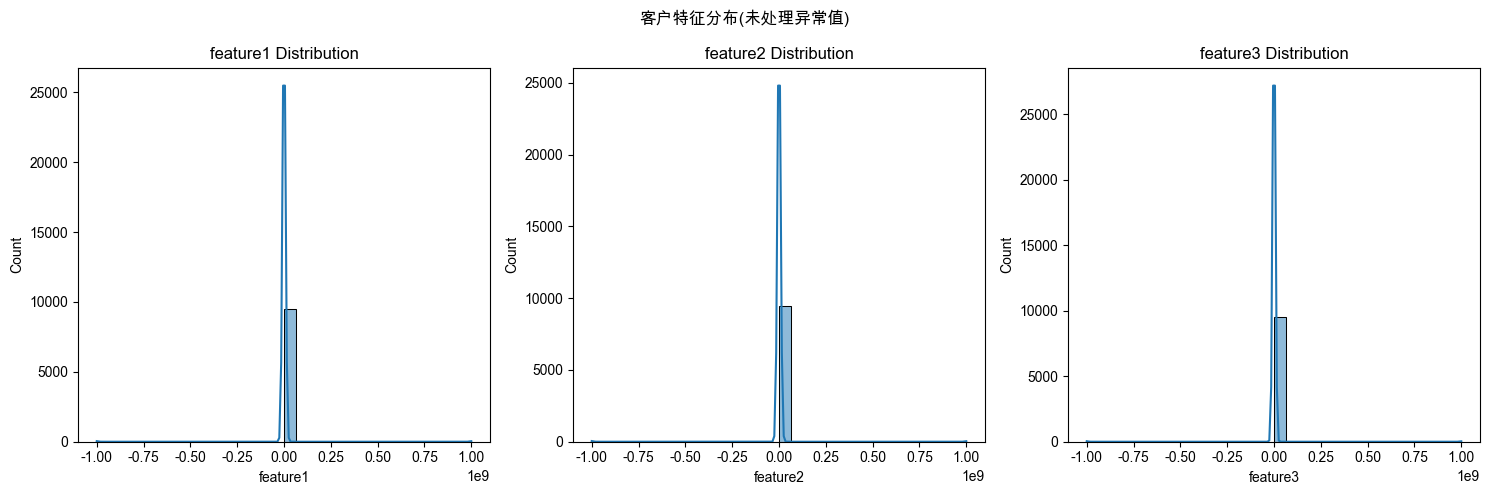

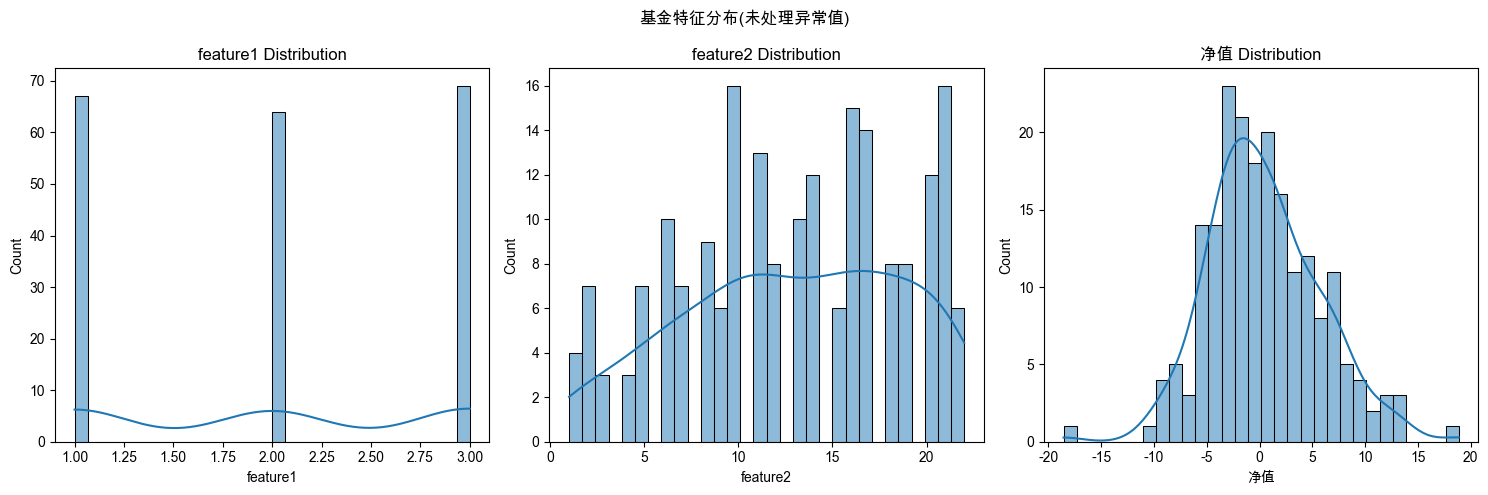

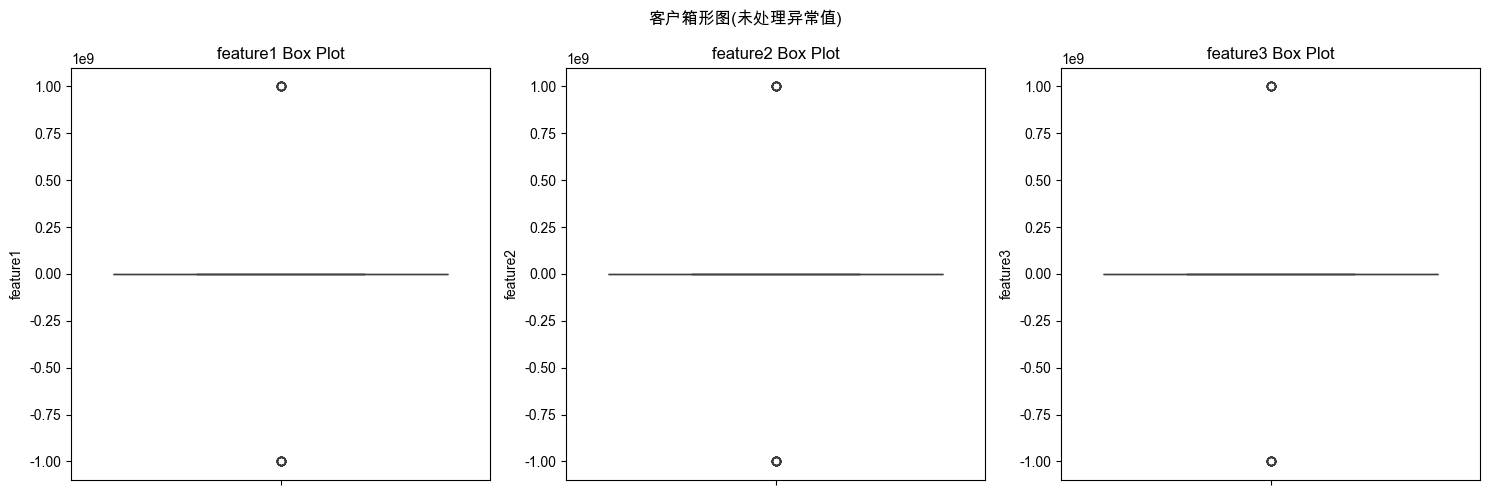

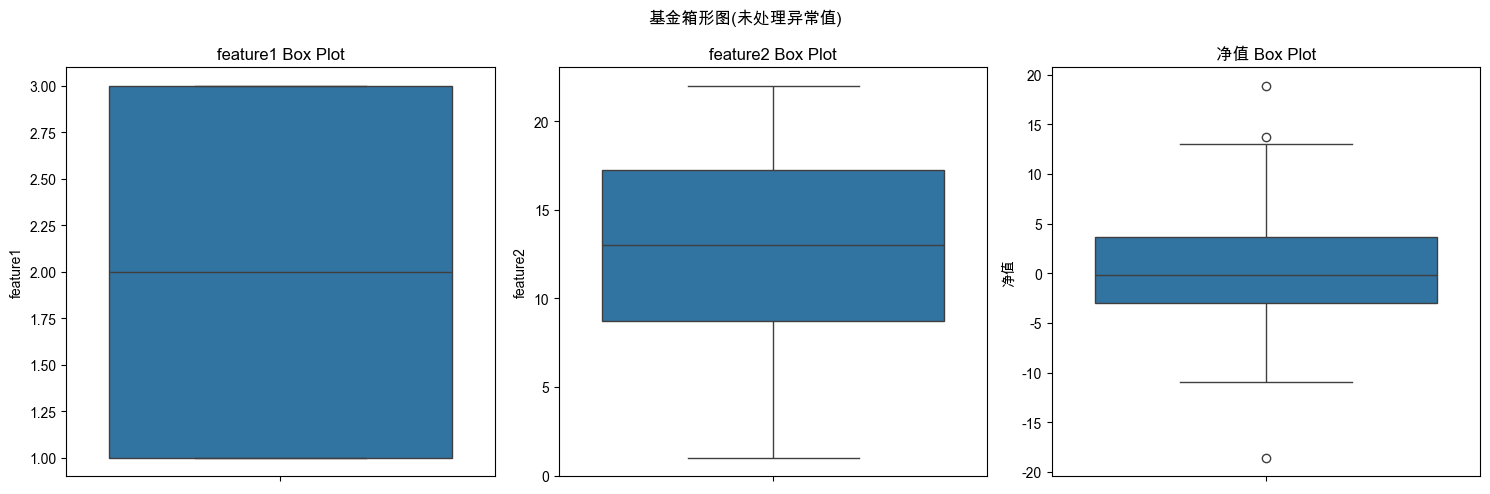

In [13]:
# 选择部分数据进行outlier可视化
client_features = ['feature1', 'feature2', 'feature3']
fund_features = ['feature1', 'feature2', '净值']


plot_histograms(client_data, client_features, '客户特征分布(未处理异常值)')
plot_histograms(fund_data, fund_features, '基金特征分布(未处理异常值)')


plot_boxplots(client_data, client_features, '客户箱形图(未处理异常值)')
plot_boxplots(fund_data, fund_features, '基金箱形图(未处理异常值)')

In [14]:
# 使用max/min 取代outlier原值

# def cap_outliers_all_features(df, threshold=1.5, is_train=True):
#     for column in df.select_dtypes(include=['float64', 'int64']):
#         if is_train:
#             Q1 = df[column].quantile(0.25)
#             Q3 = df[column].quantile(0.75)
#             IQR = Q3 - Q1
#             lower_bound = Q1 - threshold * IQR
#             upper_bound = Q3 + threshold * IQR
#             # store column, lower_bound, upper_bound in a df, and save it so that we can use it on testset
#         else:
#             # load stored lower/upper bounds, which are saved during training
        
#         df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    
#     return df

def cap_outliers_all_features(df, threshold=1.5, is_train=True, bounds_file='../models/cap_bounds.pkl'):
    bounds = {}
    if is_train:
        for column in df.select_dtypes(include=['float64', 'int64']):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            # 存储每列的界限
            bounds[column] = {'lower': lower_bound, 'upper': upper_bound}
            
            # 削顶异常值
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

        # 保存界限
        with open(bounds_file, 'wb') as f:
            pickle.dump(bounds, f)

    else:
        # 加载保存的界限
        with open(bounds_file, 'rb') as f:
            loaded_bounds = pickle.load(f)

        for column in df.select_dtypes(include=['float64', 'int64']):
            if column in loaded_bounds:
                lower_bound = loaded_bounds[column]['lower']
                upper_bound = loaded_bounds[column]['upper']

                # 削顶异常值
                df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df


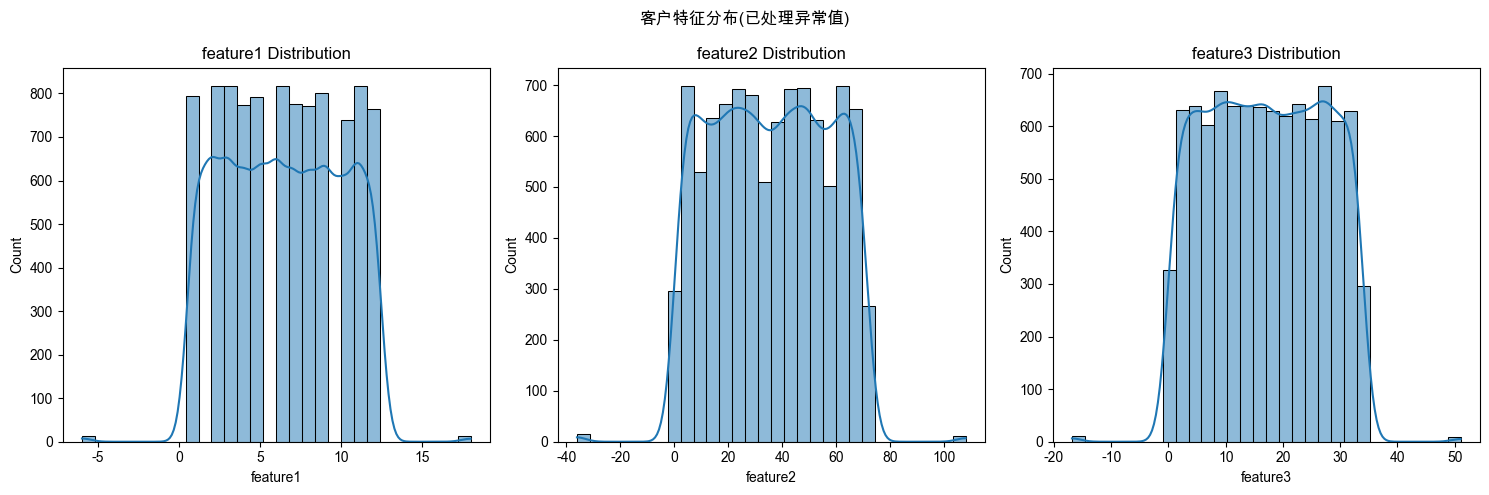

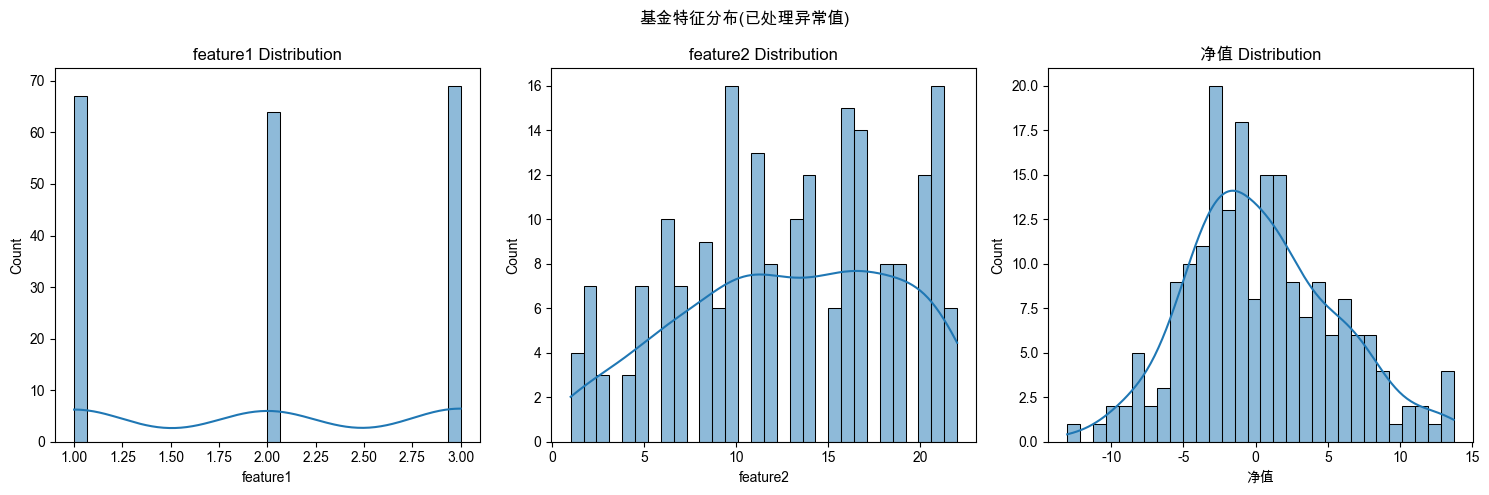

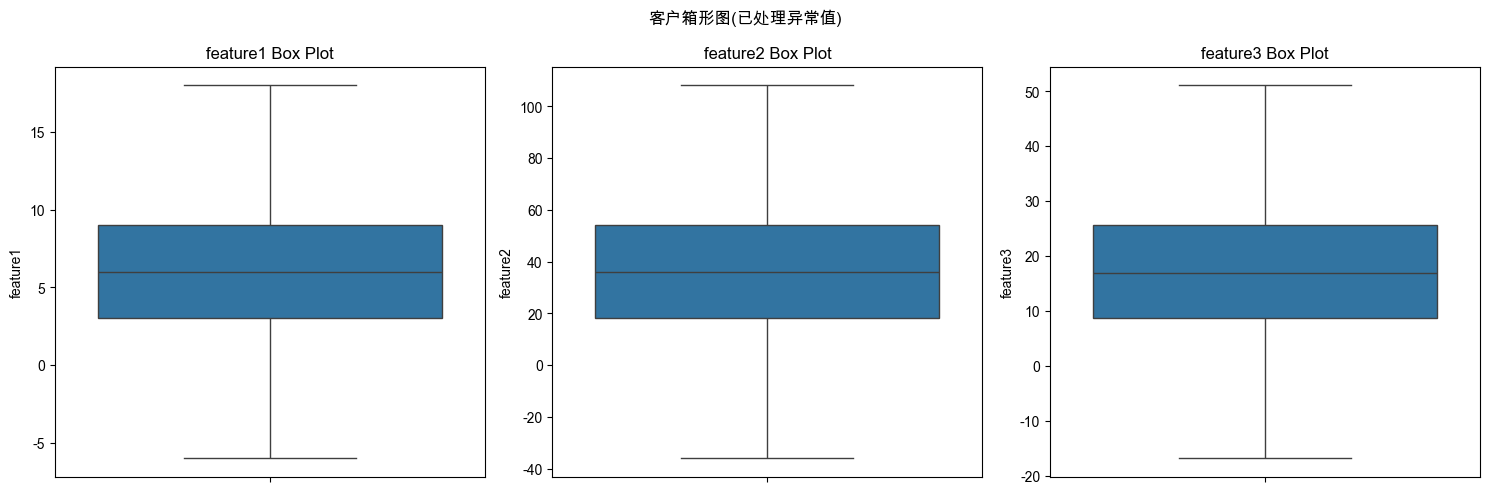

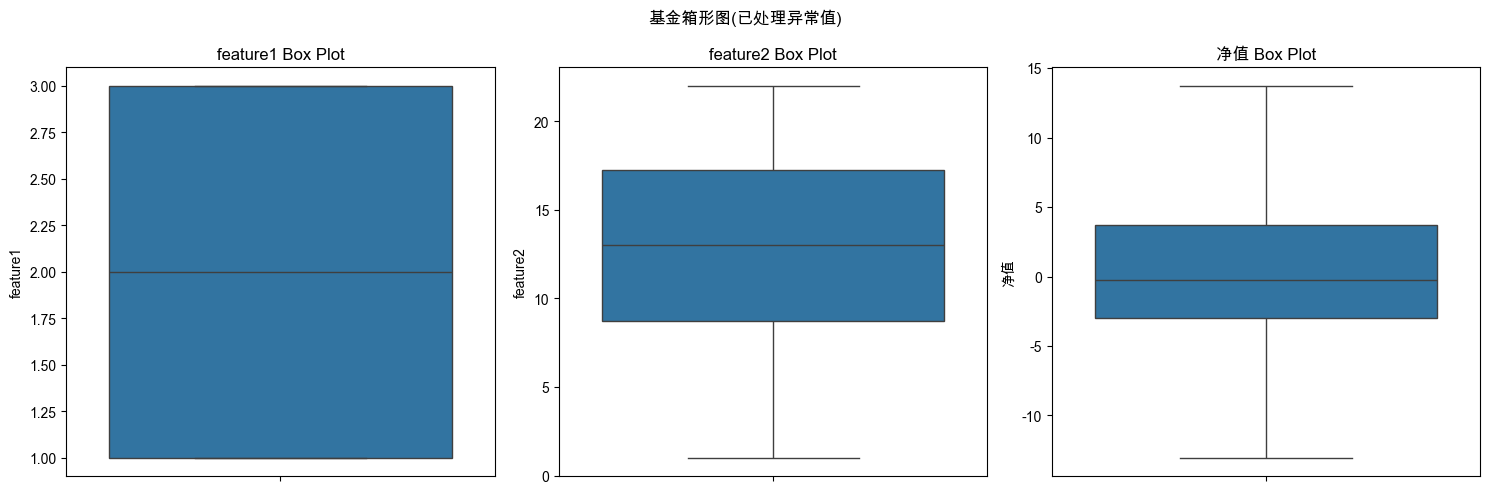

In [15]:
client_data_capped = cap_outliers_all_features(client_data)
fund_data_capped = cap_outliers_all_features(fund_data)

plot_histograms(client_data_capped, client_features, '客户特征分布(已处理异常值)')
plot_histograms(fund_data_capped, fund_features, '基金特征分布(已处理异常值)')


plot_boxplots(client_data_capped, client_features, '客户箱形图(已处理异常值)')
plot_boxplots(fund_data_capped, fund_features, '基金箱形图(已处理异常值)')

## 1.5 对数值特征进行Z分数标准化

In [16]:
def scale_features(data, scaler_file, is_train=True):
    # 选择数值型特征
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numerical_features = data.select_dtypes(include=numerics)

    if is_train:
        # 训练模式下, 初始化标准化器
        scaler = StandardScaler()
        numerical_features_scaled = scaler.fit_transform(numerical_features)
        # 保存标准化器
        with open(scaler_file, 'wb') as f:
            pickle.dump(scaler, f)
    else:
        # 测试模式下, 加载训练中保存的scaler
        with open(scaler_file, 'rb') as f:
            scaler = pickle.load(f)
        numerical_features_scaled = scaler.transform(numerical_features)

    numerical_features_scaled = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)

    # 将标准化后的数值特征与原始数据集合并
    processed_data = data.copy()
    processed_data[numerical_features.columns] = numerical_features_scaled

    return processed_data

# # 使用函数的例子
# # 对客户数据进行标准化
# client_data_scaled = scale_features(client_data, '../models/scaler_client.pkl', is_train=True)
# # 对基金数据进行标准化
# fund_data_scaled = scale_features(fund_data, '../models/scaler_fund.pkl', is_train=True)


In [17]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# client_numerical_features = client_data_capped.select_dtypes(include=numerics)
# fund_numerical_features = fund_data_capped.select_dtypes(include=numerics)


# # 初始化标准化器, 使用完毕后需要保存scaler的参数, 已供新数据预测时处理数据使用
# scaler = StandardScaler()

# # 对客户数据的数值型特征进行标准化
# client_numerical_features_scaled = scaler.fit_transform(client_numerical_features)
# client_numerical_features_scaled = pd.DataFrame(client_numerical_features_scaled, columns=client_numerical_features.columns)
# # 保存 OneHotEncoder 对象
# with open('scaler_client.pkl', 'wb') as f:
#     pickle.dump(scaler, f)
# # with open('scaler_client.pkl', 'rb') as f:
# #     onehot_client = pickle.load(f)
# # X_test_transformed = onehot_client.transform(X_test)

# # 对基金数据的数值型特征进行标准化
# fund_numerical_features_scaled = scaler.fit_transform(fund_numerical_features)
# fund_numerical_features_scaled = pd.DataFrame(fund_numerical_features_scaled, columns=fund_numerical_features.columns)
# with open('scaler_fund.pkl', 'wb') as f:
#     pickle.dump(scaler, f)


# # 将标准化后的数值特征与原始数据集合并
# client_data_capped[client_numerical_features.columns] = client_numerical_features_scaled
# fund_data_capped[fund_numerical_features.columns] = fund_numerical_features_scaled

# client_data_capped.head()
# fund_data_capped.head()


## 1.6 对客户/基金数据的类别型变量做one-hot编码

In [18]:
import pandas as pd
import pickle
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(data, columns, encoder_file, is_train=True):
    # 根据is_train标志初始化或加载OneHotEncoder
    if is_train:
        encoder = OneHotEncoder(sparse=False)
    else:
        with open(encoder_file, 'rb') as f:
            encoder = pickle.load(f)

    # 数据的独热编码
    categorical_data = data[columns]
    if is_train:
        encoded_data = encoder.fit_transform(categorical_data)
        # 保存OneHotEncoder
        with open(encoder_file, 'wb') as f:
            pickle.dump(encoder, f)
    else:
        encoded_data = encoder.transform(categorical_data)

    # 将独热编码的列添加回原始DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns))
    processed_data = data.drop(columns, axis=1).join(encoded_df)

    return processed_data

# # 使用函数的例子
# client_processed = one_hot_encode(client_data, ['客户公司名称'], '../models/onehot_client.pkl', is_train=True)
# fund_processed = one_hot_encode(fund_data, ['基金公司'], '../models/onehot_fund.pkl', is_train=True)


In [19]:
# # 确定需要进行one-hot编码的类别型列, 对于基金代码/客户编号, 我们不做处理, 留作index
# client_categorical_columns = ['客户公司名称']
# fund_categorical_columns = ['基金公司']

# # 初始化 OneHotEncoder, 使用完毕后需要保存OneHotEncoder的参数, 已供新数据预测时处理数据使用
# encoder = OneHotEncoder(sparse=False)

# # 客户数据
# client_categorical = client_data_capped[client_categorical_columns]
# client_encoded = encoder.fit_transform(client_categorical)
# client_encoded_df = pd.DataFrame(client_encoded, columns=encoder.get_feature_names_out(client_categorical_columns))
# with open('onehot_client.pkl', 'wb') as f:
#     pickle.dump(encoder, f)


# # 基金数据
# fund_categorical = fund_data_capped[fund_categorical_columns]
# fund_encoded = encoder.fit_transform(fund_categorical)
# fund_encoded_df = pd.DataFrame(fund_encoded, columns=encoder.get_feature_names_out(fund_categorical_columns))
# with open('onehot_fund.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# # 将onehot编码的列添加回原始DataFrame
# client_processed = client_data_capped.drop(client_categorical_columns, axis=1).join(client_encoded_df)
# fund_processed = fund_data_capped.drop(fund_categorical_columns, axis=1).join(fund_encoded_df)



## 1.7 根据客户的第1、2、3、4选择基金构建评分向量 y

按照第一、二、三、四选择的顺序, 帮助客户对基金进行评分, 分别为4、3、2、1, 并构建Multi-Hot向量
原因:
1. 这样的形式符合模型预测的输出形式, 且评分水平客观且直接, 处理上算法和时间成本都较低
2. 没有使用复杂的技巧, 如图随机游走, 原因是基金的购买优先级并没有时间先后关联, 不适合使用图算法, 否则平添算法复杂度和时间成本

In [20]:
def create_rating_and_save(client_processed, fund_processed, rating_file):
    # 提取基金代码作为列，以构建评分向量的模板
    fund_codes = fund_processed['基金代码'].unique()

    # 创建一个空的DataFrame来存储评分向量，使用客户编号作为索引
    client_ratings = pd.DataFrame(0, index=client_processed['客户编号'], columns=fund_codes)

    # 定义评分体系
    ratings = {'第一选择基金': 4, '第二选择基金': 3, '第三选择基金': 2, '第四选择基金': 1}

    # 填充评分向量
    for choice, score in ratings.items():
        for index, row in client_processed.iterrows():
            fund_code = row[choice]
            if pd.notna(fund_code) and fund_code in fund_codes:
                client_id = row['客户编号']
                client_ratings.at[client_id, fund_code] = score

    # 重置索引，将客户编号作为一列
    client_ratings = client_ratings.reset_index()

    # 保存评分向量到CSV文件
    client_ratings.to_csv(rating_file, index=False)

    return client_ratings

# # 使用函数的示例
# client_processed = pd.read_csv('../data/客户数据processed.csv')
# fund_processed = pd.read_csv('../data/基金数据processed.csv')
# client_ratings = create_rating_matrix(client_processed, fund_processed)

# # 检查构建的评分向量
# print(client_ratings.head())


# 2 整合所有数据预处理操作

## 2.1 处理基金数据

In [21]:
def process_fund(fund_data):
    fund_data = process_fund_date(fund_data)
    fund_data = remove_noninf(fund_data)
    fund_data = fill_blank_entries(fund_data)
    fund_data = cap_outliers_all_features(fund_data, bounds_file='../models/cap_bounds_fund.pkl', is_train=True)
    fund_data = scale_features(fund_data, '../models/scaler_fund.pkl', is_train=True)
    fund_data = one_hot_encode(fund_data, ['基金公司'], '../models/onehot_fund.pkl', is_train=True)
    return fund_data

fund_data = pd.read_csv('../data/raw/基金数据.csv')
fund_processed = process_fund(fund_data)
fund_processed.to_csv('../data/processed/基金processed.csv', index=False)

## 2.2 处理客户训练集/测试集

In [22]:
def process_client(client_data, is_train=True):
    client_data = remove_redundant_client_col(client_data)
    # print(client_data.head())
    client_data = remove_noninf(client_data)
    client_data = fill_blank_entries(client_data)
    client_data = cap_outliers_all_features(client_data, bounds_file='../models/cap_bounds_client.pkl', is_train=is_train)
    client_data = scale_features(client_data, '../models/scaler_client.pkl', is_train=is_train)
    client_data = one_hot_encode(client_data, ['客户公司名称'], '../models/onehot_client.pkl', is_train=is_train)
    return client_data

In [23]:
# 训练集处理
client_train = pd.read_csv('../data/raw/客户train.csv')
client_train_processed = process_client(client_train, is_train=True)

# 测试集处理
client_test = pd.read_csv('../data/raw/客户test.csv')
client_test_processed = process_client(client_test, is_train=False)

client_train_processed.head()

,客户编号,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,...,客户公司名称_公司19,客户公司名称_公司2,客户公司名称_公司20,客户公司名称_公司3,客户公司名称_公司4,客户公司名称_公司5,客户公司名称_公司6,客户公司名称_公司7,客户公司名称_公司8,客户公司名称_公司9
0,C9183,-0.702047,-0.518055,-0.324655,-1.353446,1.547420,0.095529,-0.157299,1.307079,0.630695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C11092,1.018569,0.491949,-0.824773,-1.320022,0.173464,0.668823,-0.358741,0.188740,-0.384630,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,C6429,0.158261,-1.095201,1.471862,1.069793,1.718863,1.242117,-0.123725,-0.767654,1.210881,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,C0289,0.158261,1.213380,0.749964,-1.336734,1.370200,-0.859961,-0.006216,0.530122,-1.399955,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,C2627,-0.702047,-1.239487,1.510131,-1.152902,0.390119,-0.286667,0.379882,-1.666466,1.549323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3 构建评分向量 y, 并生成客户x向量

In [24]:
rating_train = create_rating_and_save(client_train_processed, fund_processed, 
                                    rating_file='../data/processed/评分train.csv')
rating_test = create_rating_and_save(client_test_processed, fund_processed, 
                                    rating_file='../data/processed/评分test.csv')

rating_train.head()

,客户编号,J0001,J0002,J0003,J0004,J0005,J0006,J0007,J0008,J0009,...,J0191,J0192,J0193,J0194,J0195,J0196,J0197,J0198,J0199,J0200
0,C9183,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C11092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C6429,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C0289,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C2627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:

client_train_processed_x = client_train_processed.drop(columns=['第一选择基金', '第二选择基金', 
                                                        '第三选择基金', '第四选择基金'])
client_test_processed_x = client_test_processed.drop(columns=['第一选择基金', '第二选择基金', 
                                                        '第三选择基金', '第四选择基金'])
client_train_processed_x.to_csv('../data/processed/客户train_x.csv', index=False)
client_test_processed_x.to_csv('../data/processed/客户test_x.csv', index=False)

client_train_processed_x.head()

,客户编号,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,...,客户公司名称_公司19,客户公司名称_公司2,客户公司名称_公司20,客户公司名称_公司3,客户公司名称_公司4,客户公司名称_公司5,客户公司名称_公司6,客户公司名称_公司7,客户公司名称_公司8,客户公司名称_公司9
0,C9183,-0.702047,-0.518055,-0.324655,-1.353446,1.547420,0.095529,-0.157299,1.307079,0.630695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C11092,1.018569,0.491949,-0.824773,-1.320022,0.173464,0.668823,-0.358741,0.188740,-0.384630,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,C6429,0.158261,-1.095201,1.471862,1.069793,1.718863,1.242117,-0.123725,-0.767654,1.210881,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,C0289,0.158261,1.213380,0.749964,-1.336734,1.370200,-0.859961,-0.006216,0.530122,-1.399955,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,C2627,-0.702047,-1.239487,1.510131,-1.152902,0.390119,-0.286667,0.379882,-1.666466,1.549323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3 相关性分析

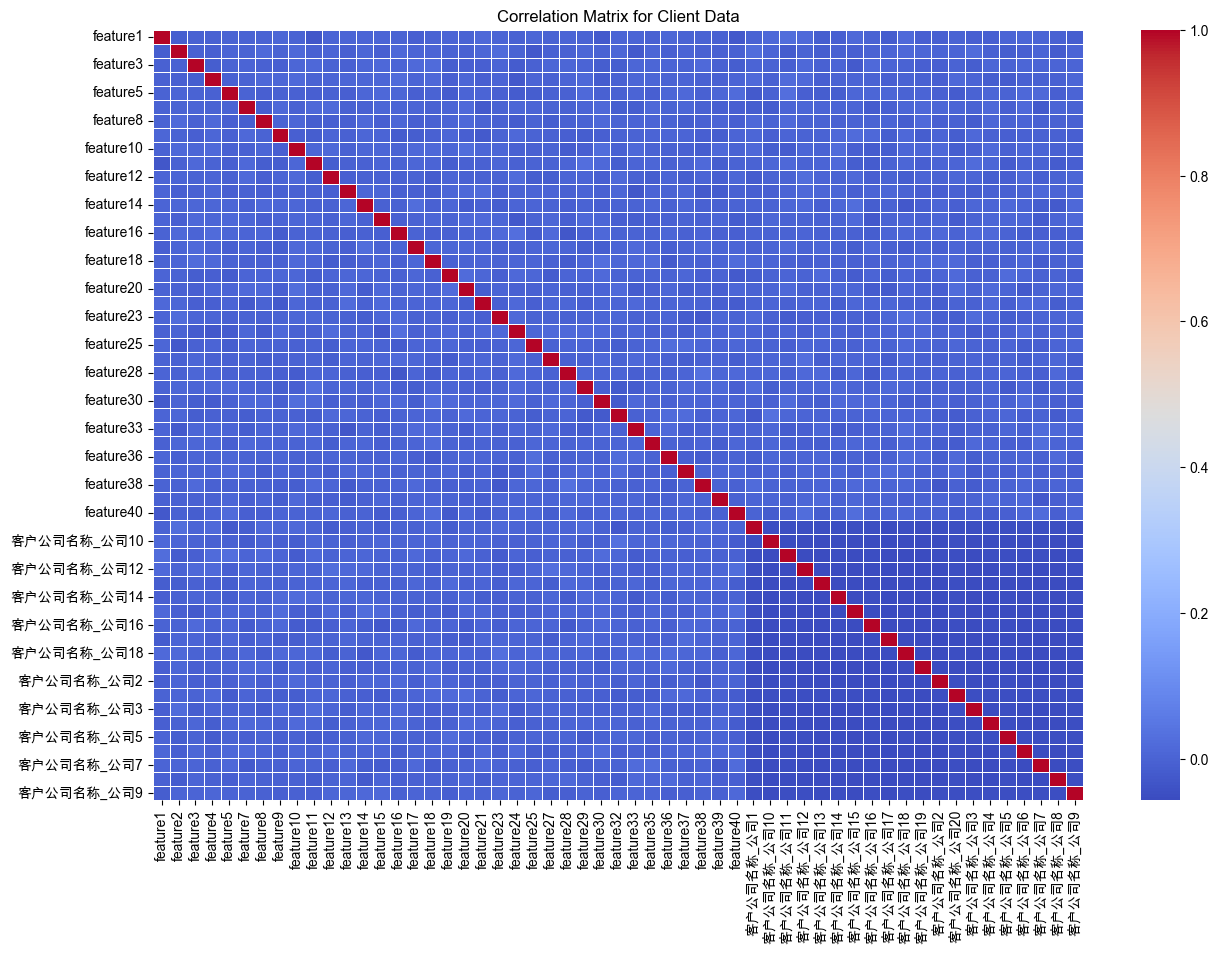

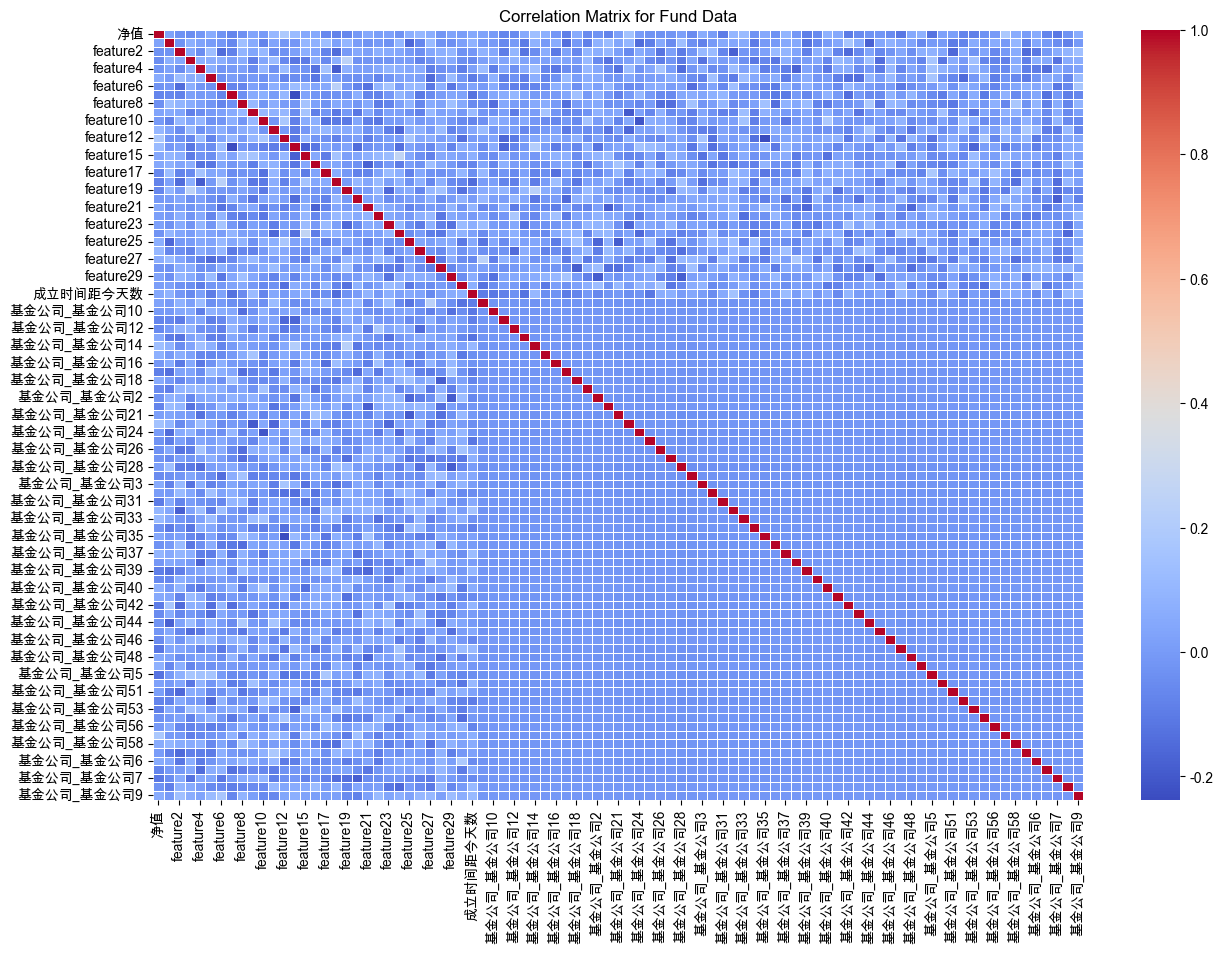

In [26]:
# Computing the correlation matrix for the Client Data
client_data_numeric_only = client_train_processed.select_dtypes(include=['float64', 'int64'])
client_correlation = client_data_numeric_only.corr()

# Plotting the heatmap for the Client Data correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(client_correlation, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for Client Data')
plt.savefig('../output/Corr_Client.png')
plt.show()

# Computing the correlation matrix for the Fund Data
fund_data_numeric_only = fund_processed.select_dtypes(include=['float64', 'int64'])
fund_correlation = fund_data_numeric_only.corr()

# Plotting the heatmap for the Fund Data correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(fund_correlation, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for Fund Data')
plt.savefig('../output/Corr_Fund.png')
plt.show()

可以看出客户和基金的数值型特征通过了相关性测试, 没有多重共线性的问题